# Librerías

In [25]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import wfdb
from scipy.stats import skew, kurtosis, iqr, ks_2samp
from scipy.signal import welch, find_peaks, periodogram
from sklearn.experimental import enable_halving_search_cv
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, plot_importance

import matplotlib.pyplot as plt



from sklearn.model_selection import (
    StratifiedKFold, cross_val_predict, GridSearchCV, train_test_split,
    HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, VotingClassifier
)


import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Lectura de archivos y creación de variables con los records

In [26]:

# Rutas
csv_path = "c:/Users/perez/Desktop/Examen/train_e1.csv"
base_dir = "c:/Users/perez/Desktop/Examen/records500"

# Cargar CSV
df = pd.read_csv(csv_path)

# Función para calcular la entropía espectral
def spectral_entropy(psd):
    psd_norm = psd / np.sum(psd)
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))  # +1e-12 evita log(0)

# Función para estimar la frecuencia cardíaca
def estimate_hr(signal, fs):
    peaks, _ = find_peaks(signal, distance=fs*0.6)  # al menos 0.6s entre latidos
    if len(peaks) < 2:
        return np.nan
    rr_intervals = np.diff(peaks) / fs  # en segundos
    hr = 60.0 / np.mean(rr_intervals)  # en bpm
    return hr

# Función para calcular cruces por cero
def zero_crossings(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

# Función para extraer características de un registro WFDB
def extract_features(record, row):
    data = record.p_signal
    fs = record.fs
    feature_dict = {
        'ecg_id': row.get('ecg_id', np.nan),
        'age': row.get('age', np.nan),
        'sex': row.get('sex', np.nan),
        'decive' :row.get('device', np.nan),
        'date':row.get('recording_date',np.nan),
        'NOT_NORM': row.get('NOT_NORM', np.nan),
    }

    for i, name in enumerate(record.sig_name):
        canal = data[:, i]

        # Estadísticas básicas
        feature_dict[f'{name}_mean'] = np.mean(canal)
        feature_dict[f'{name}_std'] = np.std(canal)
        feature_dict[f'{name}_min'] = np.min(canal)
        feature_dict[f'{name}_max'] = np.max(canal)
        feature_dict[f'{name}_median'] = np.median(canal)
        feature_dict[f'{name}_iqr'] = iqr(canal)
        feature_dict[f'{name}_skew'] = skew(canal)
        feature_dict[f'{name}_kurtosis'] = kurtosis(canal)
        feature_dict[f'{name}_energy'] = np.sum(canal ** 2)
        feature_dict[f'{name}_rms'] = np.sqrt(np.mean(canal ** 2))

        # 🧠 Características adicionales

        # 1. Entropía espectral y frecuencia dominante
        freqs, psd = welch(canal, fs=fs)
        feature_dict[f'{name}_spec_entropy'] = spectral_entropy(psd)
        feature_dict[f'{name}_dom_freq'] = freqs[np.argmax(psd)]

        # 2. Estimación de frecuencia cardíaca
        feature_dict[f'{name}_hr_est'] = estimate_hr(canal, fs)

        # 3. Cruces por cero
        feature_dict[f'{name}_zero_cross'] = zero_crossings(canal)

    return feature_dict

# Extracción de características
features = [
    extract_features(
        wfdb.rdrecord(os.path.normpath(os.path.join(base_dir, row['filename_hr']))),
        row
    )
    for _, row in tqdm(df.iterrows(), total=len(df))
]

# Guardar resultados
df_features = pd.DataFrame(features)
df_features.to_csv("caracteristicas_ecg_extendido.csv", index=False)
print("✅ Características extendidas extraídas y guardadas en caracteristicas_ecg_extendido.csv")




 70%|███████   | 10770/15285 [03:27<01:14, 60.55it/s]C:\Users\perez\AppData\Local\Temp\ipykernel_16716\1930704809.py:10: RuntimeWarning:

invalid value encountered in divide

100%|██████████| 15285/15285 [04:43<00:00, 53.93it/s]


✅ Características extendidas extraídas y guardadas en caracteristicas_ecg_extendido.csv


In [27]:
df_car=pd.read_csv("./caracteristicas_ecg_extendido.csv")

In [28]:
df_car

,ecg_id,age,sex,decive,date,NOT_NORM,I_mean,I_std,I_min,I_max,...,V6_median,V6_iqr,V6_skew,V6_kurtosis,V6_energy,V6_rms,V6_spec_entropy,V6_dom_freq,V6_hr_est,V6_zero_cross
0,16286,68.0,0,CS100 3,1996-07-04 14:12:49,1,0.000540,0.163531,-0.158,1.065,...,-0.040,0.04600,4.936445,24.922223,203.534115,0.201759,3.688841,7.812500,76.530612,50
1,2647,34.0,1,CS-12 E,1989-04-09 08:52:33,0,0.001902,0.089678,-0.190,0.471,...,-0.050,0.06500,4.741523,28.268202,127.828904,0.159893,3.817994,1.953125,77.419355,37
2,11732,53.0,0,CS-12 E,1994-01-26 13:21:53,0,-0.003925,0.085735,-0.168,0.570,...,-0.052,0.09225,3.579538,16.766691,142.755529,0.168971,3.670206,3.906250,62.253580,33
3,19751,59.0,0,CS100 3,1998-10-08 15:19:32,1,-0.005651,0.175106,-0.193,1.300,...,-0.035,0.04500,4.440302,22.758314,78.636552,0.125409,3.577021,3.906250,70.019096,45
4,7898,69.0,1,AT-6 C 5.8,1992-03-22 19:11:05,0,0.000645,0.114421,-0.170,0.854,...,0.040,0.19900,-2.018618,6.510984,279.421010,0.236398,3.435446,1.953125,58.759521,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15280,15377,47.0,0,CS-12 E,1995-11-25 10:18:13,0,-0.001137,0.080278,-0.145,0.331,...,-0.050,0.48525,0.521620,-0.713633,459.959208,0.303302,3.203520,1.953125,58.900524,21
15281,5475,47.0,0,CS100 3,1990-12-06 09:29:17,0,0.000150,0.100120,-0.210,0.756,...,-0.055,0.09525,4.422296,22.768542,215.788052,0.207744,3.662858,3.906250,69.109948,42
15282,3790,75.0,1,AT-6 C,1990-02-20 14:48:42,1,-0.002194,0.190278,-0.220,1.280,...,-0.034,0.12450,4.283989,22.806535,220.949126,0.210214,3.792639,3.906250,70.967742,50
15283,21643,72.0,1,CS100 3,2000-12-11 11:51:56,1,-0.002947,0.411897,-0.614,1.597,...,-0.040,0.19700,2.364404,5.750199,928.637314,0.430961,2.373004,1.953125,63.051702,55


In [29]:
df_car["ecg_id"]=df_car["ecg_id"].astype(str)
df_car["sex"]=df_car["sex"].astype(str)
df_car["NOT_NORM"]=df_car["NOT_NORM"].astype(str)
df_car["decive"]=df_car["decive"].astype(str)
df_car['date'] = pd.to_datetime(df_car['date'], format="%Y-%m-%d %H:%M:%S")
df_car['mes'] = df_car['date'].dt.to_period('M')
df_car['año'] = df_car['date'].dt.to_period('Y')

# Revision del dataset

In [30]:
df_car.isna().sum()

ecg_id            0
age              61
sex               0
decive            0
date              0
                 ..
V6_dom_freq       0
V6_hr_est         1
V6_zero_cross     0
mes               0
año               0
Length: 176, dtype: int64

In [31]:
df_car[df_car.isnull().any(axis=1)]

,ecg_id,age,sex,decive,date,NOT_NORM,I_mean,I_std,I_min,I_max,...,V6_skew,V6_kurtosis,V6_energy,V6_rms,V6_spec_entropy,V6_dom_freq,V6_hr_est,V6_zero_cross,mes,año
267,1068,NaN,1,AT-6 C 5.5,1987-08-09 13:01:33,1,0.002307,0.064923,-0.160,0.332,...,0.716169,2.462410,181.284725,0.190413,4.443385,1.953125,81.154193,54,1987-08,1987
357,8695,NaN,0,AT-6 C 5.5,1992-08-04 10:39:12,1,-0.006617,0.312933,-0.530,1.080,...,0.636621,0.258086,216.640787,0.208154,1.937370,1.953125,76.303518,31,1992-08,1992
753,712,NaN,1,AT-6 C 5.8,1987-05-01 11:50:12,1,-0.008855,0.296705,-0.506,1.194,...,1.350887,1.739300,1156.082273,0.480850,2.216447,1.953125,85.808581,30,1987-05,1987
845,10563,NaN,1,AT-6 C 5.5,1993-07-17 23:20:11,1,0.000615,0.206616,-0.237,1.355,...,0.699940,5.553223,116.737034,0.152799,4.169926,17.578125,77.021823,34,1993-07,1993
1213,15857,NaN,1,AT-6 C,1996-03-16 13:59:54,1,-0.003556,0.265965,-1.960,0.988,...,1.676378,4.034645,251.335801,0.224203,2.958095,1.953125,71.583514,50,1996-03,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14006,7991,NaN,1,AT-6 C 5.5,1992-04-22 07:06:05,1,-0.006931,0.173235,-0.217,1.010,...,3.771787,16.194069,305.234444,0.247077,3.874734,3.906250,90.968161,64,1992-04,1992
14106,14497,NaN,1,AT-6 6,1995-07-20 11:45:46,1,0.000468,0.147261,-0.233,0.952,...,3.240166,12.726736,309.134425,0.248650,3.526918,3.906250,94.181666,68,1995-07,1995
14234,730,NaN,1,AT-6 C 5.8,1987-05-05 11:51:12,1,0.000268,0.235516,-0.326,0.780,...,1.551919,2.270976,159.260344,0.178471,2.164369,1.953125,87.627791,33,1987-05,1987
15032,18580,NaN,1,CS100 3,1997-09-21 10:07:50,0,-0.004068,0.130630,-0.645,0.540,...,3.393522,15.111770,159.035251,0.178345,3.736407,1.953125,58.708415,37,1997-09,1997


In [32]:
df_car['age'].fillna(df_car['age'].median(), inplace=True)

C:\Users\perez\AppData\Local\Temp\ipykernel_16716\1706244469.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [33]:
df_car.dropna(inplace=True)

In [34]:
df_car.duplicated().sum()

np.int64(0)

In [35]:
df_car.columns

Index(['ecg_id', 'age', 'sex', 'decive', 'date', 'NOT_NORM', 'I_mean', 'I_std',
       'I_min', 'I_max',
       ...
       'V6_skew', 'V6_kurtosis', 'V6_energy', 'V6_rms', 'V6_spec_entropy',
       'V6_dom_freq', 'V6_hr_est', 'V6_zero_cross', 'mes', 'año'],
      dtype='object', length=176)

# EDA


In [36]:
df_car.describe()

,age,date,I_mean,I_std,I_min,I_max,I_median,I_iqr,I_skew,I_kurtosis,...,V6_median,V6_iqr,V6_skew,V6_kurtosis,V6_energy,V6_rms,V6_spec_entropy,V6_dom_freq,V6_hr_est,V6_zero_cross
count,15284.000000,15284,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,...,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000,15284.000000
mean,59.774405,1993-09-17 14:32:35.204265984,-0.001947,0.142504,-0.300429,0.879824,-0.027372,0.092587,2.862697,13.930900,...,-0.033065,0.138101,3.049045,15.649914,300.443667,0.203541,3.645991,4.305462,71.808258,47.741822
min,2.000000,1984-11-09 09:17:34,-4.430192,0.025615,-10.671000,-0.599000,-5.575000,0.020000,-8.691270,-1.349649,...,-1.930000,0.016000,-14.941143,-1.384273,3.956862,0.028131,1.415053,1.953125,49.968770,0.000000
25%,50.000000,1990-11-25 10:01:39,-0.003925,0.099871,-0.339000,0.605000,-0.037000,0.060000,1.917420,6.804603,...,-0.047000,0.061250,1.992958,7.878982,90.923498,0.134851,3.504670,3.906250,64.034152,35.000000
50%,62.000000,1993-09-01 22:06:20.500000,-0.001173,0.129849,-0.242000,0.822000,-0.025000,0.078000,3.073804,13.055676,...,-0.033000,0.092000,3.407503,15.320116,155.565266,0.176389,3.696062,3.906250,70.937231,44.000000
75%,72.000000,1996-07-16 10:10:40.500000,0.001447,0.168196,-0.183000,1.070000,-0.015000,0.105000,3.959901,19.338567,...,-0.017000,0.150000,4.313709,22.148820,272.029358,0.233251,3.858390,3.906250,78.516903,55.000000
max,95.000000,2001-06-11 16:43:01,0.861453,5.834101,0.163000,30.658000,0.904000,1.445500,15.101675,289.473185,...,0.694000,4.220000,11.029017,519.465203,77243.350814,3.930480,6.570924,50.781250,99.729898,533.000000
std,17.004582,NaN,0.054159,0.094539,0.275887,0.576583,0.068956,0.061667,1.536531,9.953719,...,0.040861,0.169861,1.709206,10.880038,1263.264170,0.136605,0.383630,2.240625,10.006019,22.525990


# Gráficas

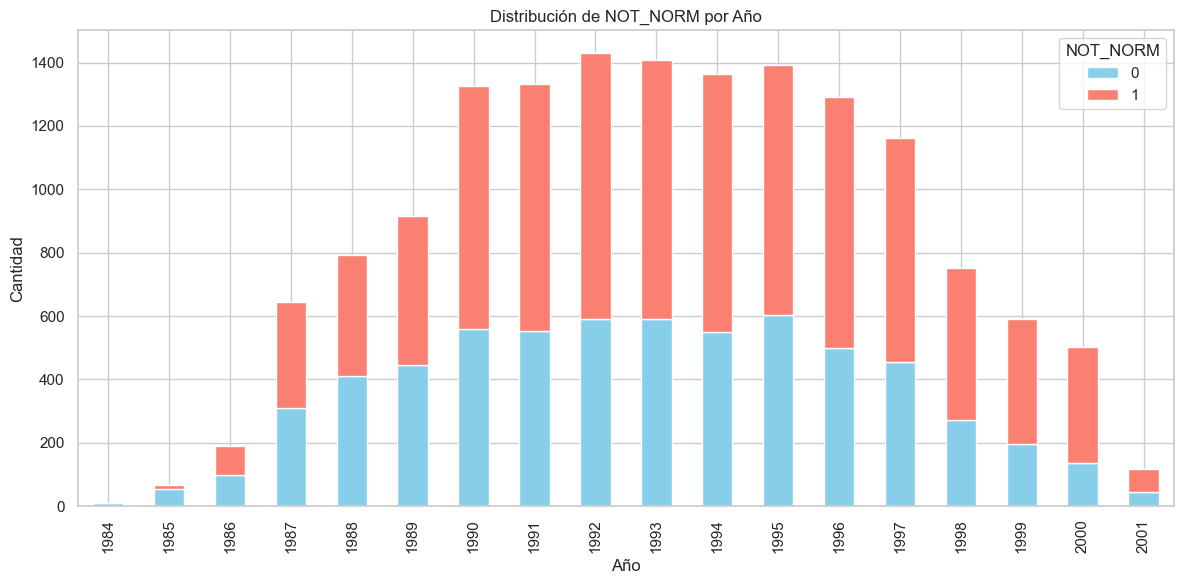

In [37]:

# Agrupa por año y cuenta la frecuencia de cada clase
conteo_por_año = df_car.groupby(df_car['año'])['NOT_NORM'].value_counts().unstack().fillna(0)

# Grafica de barras apiladas
conteo_por_año.plot(kind='bar', stacked=True, figsize=(12,6), color=['skyblue', 'salmon'])
plt.title('Distribución de NOT_NORM por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad')

plt.legend(title='NOT_NORM')
plt.tight_layout()
plt.show()

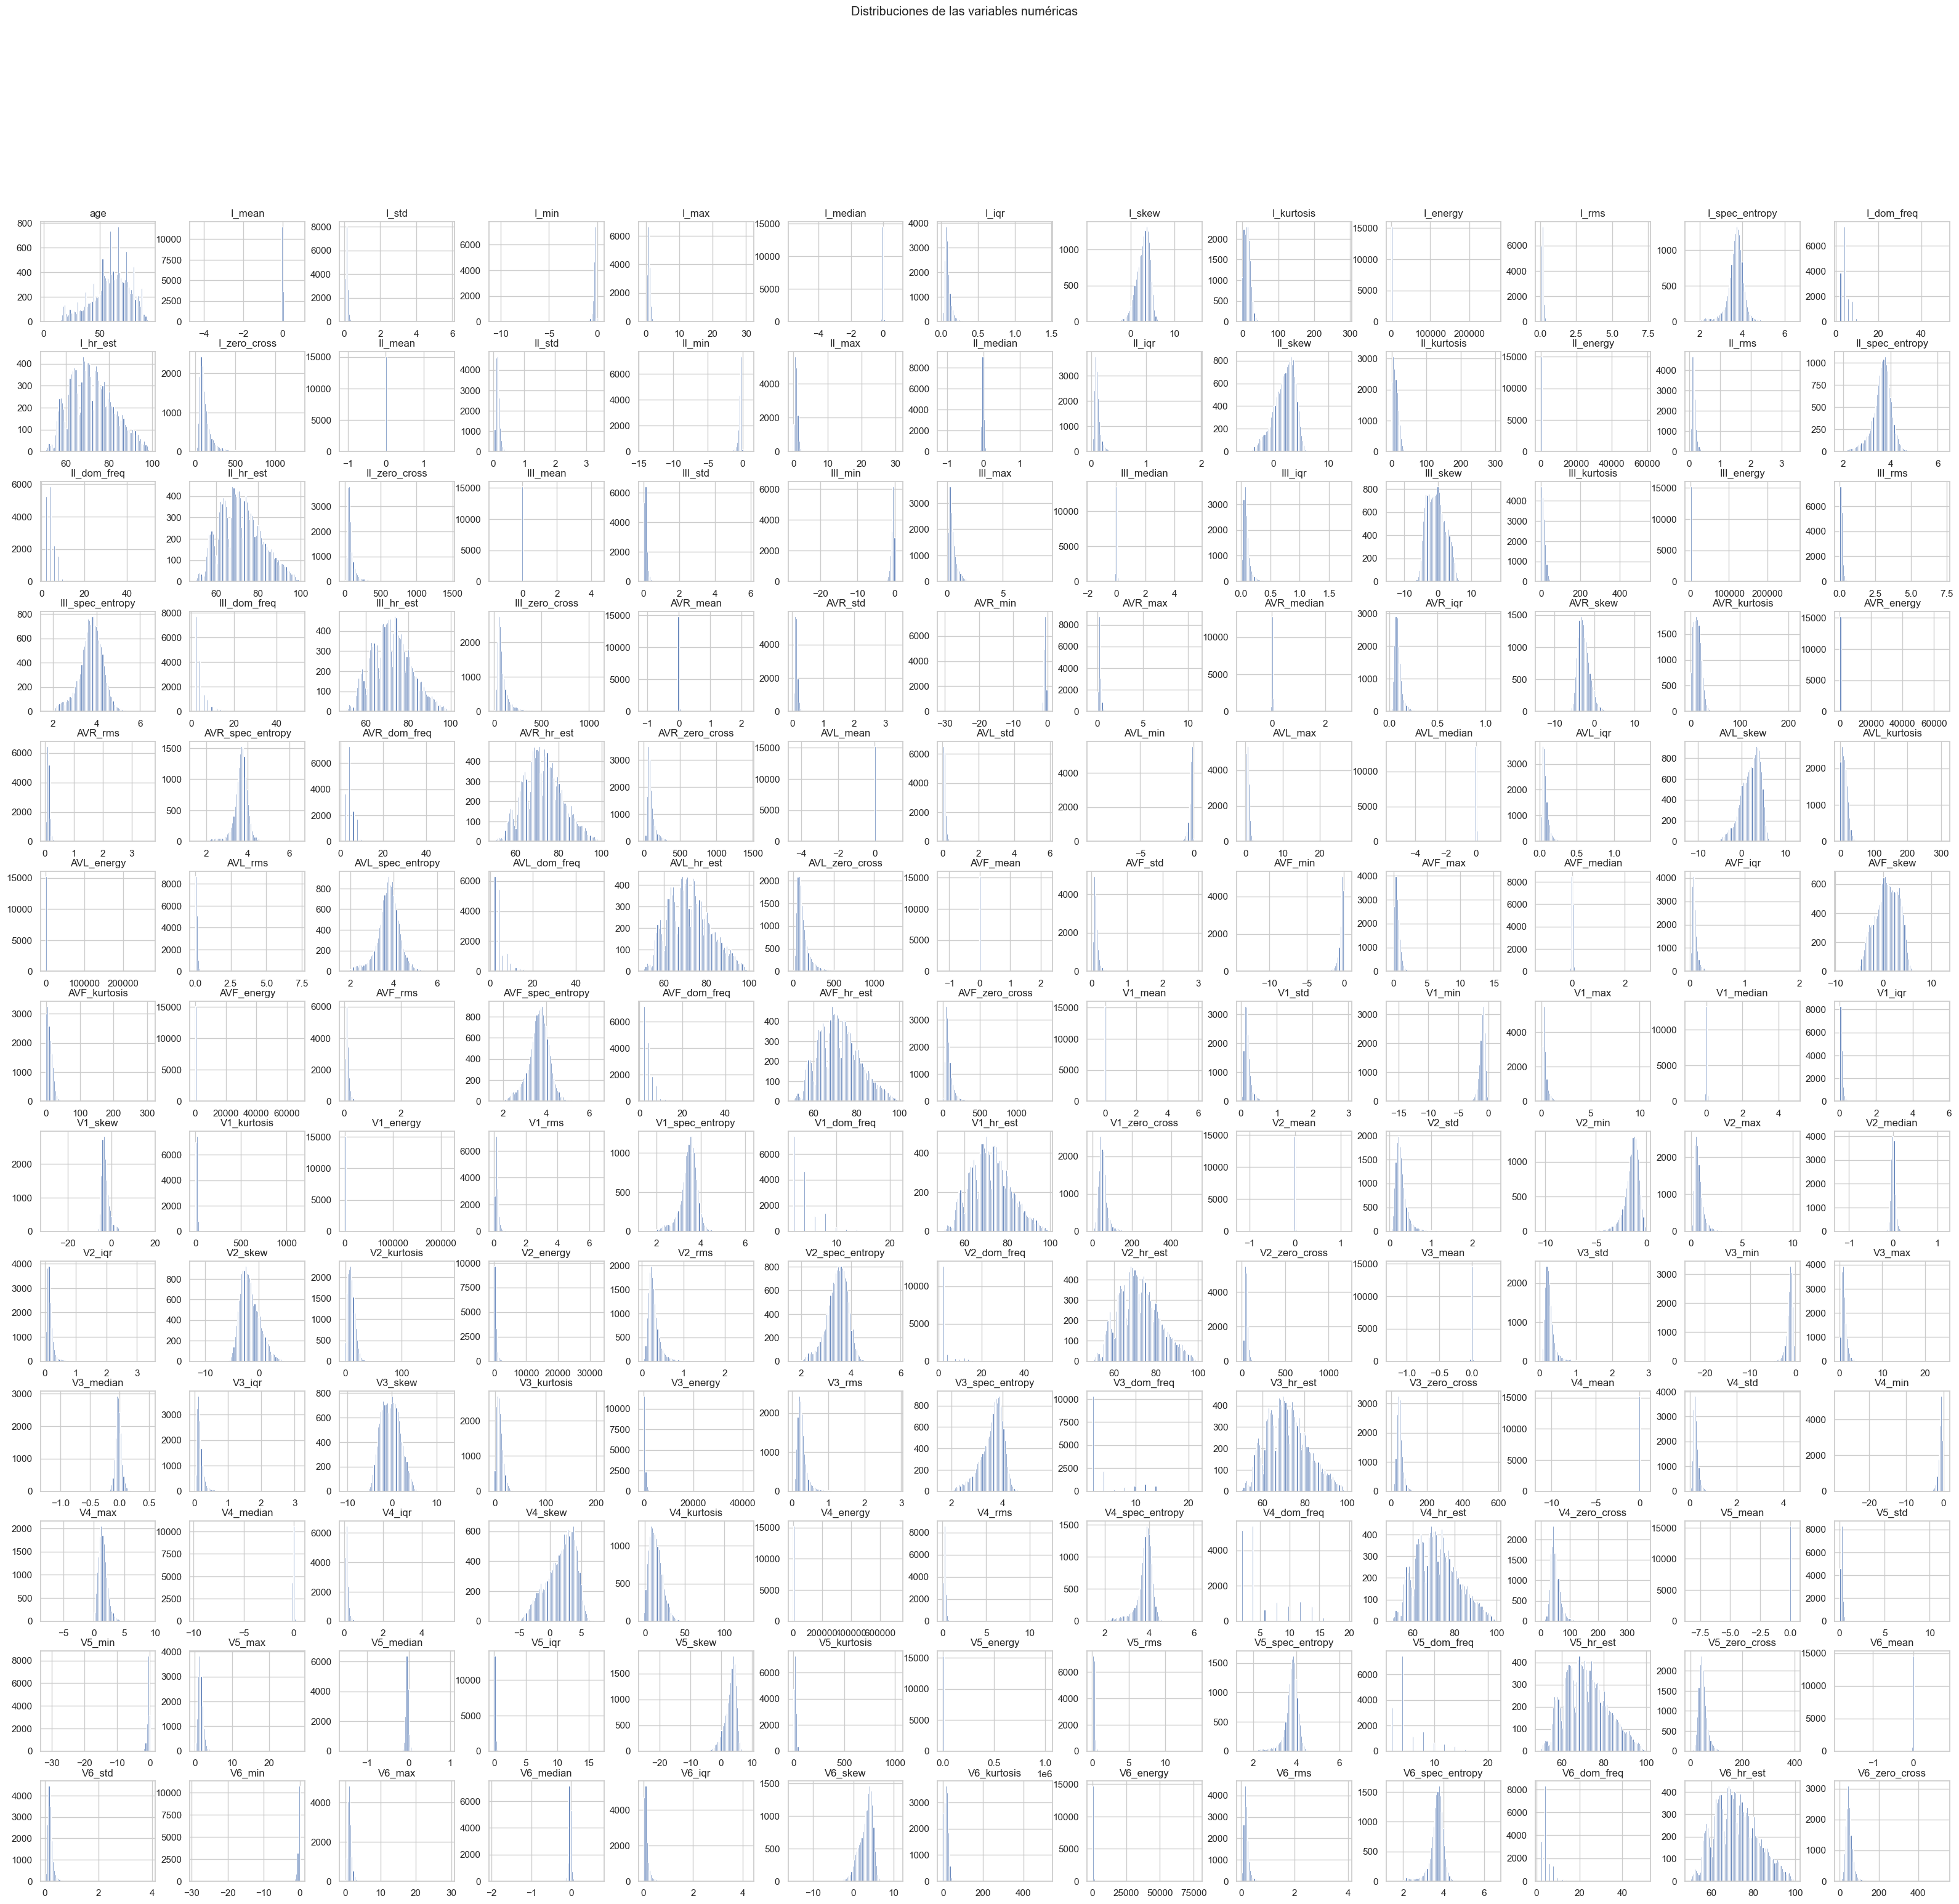

In [ ]:

# Asegura estilo
sns.set(style='whitegrid')

# Carga del dataframe
df = df_car.copy()

#  Distribución de variables numéricas (histograma y boxplot de una sola, por ejemplo 'II_mean')
num_vars = [col for col in df.columns if col not in ['ecg_id', 'sex', 'NOT_NORM', 'decive', 'date', 'mes', 'año']]

# Histograma para varias variables
df[num_vars].hist(figsize=(40, 35), bins=80)
plt.suptitle("Distribuciones de las variables numéricas")
plt.show()






In [ ]:


df=df_car.copy()
# Variables numéricas
num_vars = [col for col in df.columns if col not in ['ecg_id', 'sex', 'NOT_NORM']]

#  Distribución del target (NOT_NORM)
fig1 = px.histogram(df, x='NOT_NORM', title='Distribución del Target (NOT_NORM)', labels={'NOT_NORM': 'Clase'}, color='NOT_NORM')
fig1.show()


#  Histograma interactivo de varias variables
fig3 = px.histogram(df, x='V2_std', color='NOT_NORM', nbins=30, marginal='rug', title='Distribución de V2_std por clase')
fig3.show()
fig4 = px.histogram(df, x='age', color='NOT_NORM', barmode='group', title='Distribución de NOT_NORM por edad')
fig4.show()

#  Distribución de NOT_NORM por sexo
fig5 = px.histogram(df, x='sex', color='NOT_NORM', barmode='group', title='Distribución de NOT_NORM por sexo')
fig5.show()


# Modelado

In [40]:
df = pd.get_dummies(df_car, columns=['sex', 'decive', 'año'], drop_first=True)

In [51]:

model_result_1 = []

def predict_cv_2(ml_model, model_name, X, y, cv=5, scoring='roc_auc', param_grid=None, use_pipeline=False, steps=None):
    '''
    Evalúa un modelo con validación cruzada, opcionalmente usando PCA mediante un pipeline.
    También puede usar GridSearchCV. Muestra métricas, matriz de confusión y curva ROC.
    Devuelve el mejor modelo entrenado.
    
    Parámetros:
    - ml_model: el modelo base (por ejemplo, LogisticRegression)
    - model_name: nombre del modelo para visualizaciones
    - X, y: datos de entrada y etiquetas
    - cv: número de folds (default=5)
    - scoring: métrica para GridSearch (default='roc_auc')
    - param_grid: diccionario para GridSearchCV (opcional)
    - use_pipeline: True si deseas aplicar pasos como PCA (default=False)
    - steps: lista de pasos [(‘nombre’, transformador)] si `use_pipeline=True`
    '''

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    if use_pipeline:
        if not steps:
            raise ValueError("Debes proporcionar steps del pipeline si use_pipeline=True")
        # Añadimos el modelo al pipeline
        steps_pipeline = steps + [('model', ml_model)]
        ml_model = Pipeline(steps_pipeline)

    # GridSearchCV
    if param_grid:
        grid = GridSearchCV(ml_model, param_grid, cv=skf, scoring=scoring, n_jobs=-1)
        grid.fit(X, y)
        ml_model = grid.best_estimator_
        print(f"Best parameters from GridSearch for {model_name}:\n{grid.best_params_}")
        print('-'*80)

    # Predicciones cruzadas
    y_pred = cross_val_predict(ml_model, X, y, cv=skf)
    y_prob = cross_val_predict(ml_model, X, y, cv=skf, method="predict_proba")[:, 1]

    # Métricas
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)

    print(f'Model: {model_name}')
    print(f'Accuracy:     {acc:.3f}')
    print(f'Precision:    {prec:.3f}')
    print(f'Recall:       {rec:.3f}')
    print(f'F1-score:     {f1:.3f}')
    print(f'ROC AUC:      {roc_auc:.3f}')
    print('-'*80)

    print('Classification Report:')
    print(classification_report(y, y_pred))
    print('-'*80)

    # Matriz de confusión
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Ejemplo de predicciones
    d = pd.DataFrame({'y_actual': y, 'y_pred': y_pred})
    print('Predictions sample:')
    print(d.head(10).T)
    print('-'*80)

    # Guardar resultados
    model_result_1.append({
        'model': model_name,
        'cv_accuracy': acc,
        'cv_precision': prec,
        'cv_recall': rec,
        'cv_f1': f1,
        'cv_roc_auc': roc_auc
    })

    return ml_model






### Separación y escalado

In [52]:

X = df.drop(columns=['NOT_NORM','ecg_id', 'date', 'mes'])
y = df['NOT_NORM'].astype(int)

# Asegurar valores numéricos
X = X.select_dtypes(include=[np.number])

# Estandarización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [53]:
pca = PCA(n_components=20)  #
X_pca = pca.fit_transform(X_scaled)


### Búsqueda de mejores hiperparametros para los modelos

In [44]:
models_and_grids = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {
            "C": [0.1, 1, 10],
            "solver": ['liblinear', 'lbfgs']
        }
    ),
    "DecisionTreeClassifier": (
        DecisionTreeClassifier(random_state=42),
        {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10]
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance']
        }
    ),
    "LDA": (
        LinearDiscriminantAnalysis(),
        {
            "solver": ['svd', 'lsqr']
        }
    ),
    "Naive Bayes": (
        GaussianNB(),
        {}  # No hiperparámetros
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10],
            "min_samples_split": [2, 5]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.5, 1.0]
        }
    ),
    "Bagging": (
        BaggingClassifier(random_state=42),
        {
            "n_estimators": [50, 100]
        }
    )
}


In [45]:
y_array = y.values if isinstance(y, pd.Series) else y
for name, (model, param_grid) in models_and_grids.items():
    print(f"\n🔍 GridSearch para {name}")
    grid = GridSearchCV(model, param_grid, cv=4, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_scaled, y_array)
    best_model = grid.best_estimator_
    print(f"🧪 Mejores parámetros: {grid.best_params_}")


🔍 GridSearch para Logistic Regression
🧪 Mejores parámetros: {'C': 10, 'solver': 'liblinear'}

🔍 GridSearch para DecisionTreeClassifier
🧪 Mejores parámetros: {'max_depth': 5, 'min_samples_split': 2}

🔍 GridSearch para KNN
🧪 Mejores parámetros: {'n_neighbors': 7, 'weights': 'distance'}

🔍 GridSearch para LDA
🧪 Mejores parámetros: {'solver': 'lsqr'}

🔍 GridSearch para Naive Bayes
🧪 Mejores parámetros: {}

🔍 GridSearch para Random Forest
🧪 Mejores parámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

🔍 GridSearch para Gradient Boosting
🧪 Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

🔍 GridSearch para AdaBoost
🧪 Mejores parámetros: {'learning_rate': 1.0, 'n_estimators': 100}

🔍 GridSearch para Bagging
🧪 Mejores parámetros: {'n_estimators': 100}


In [46]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [47]:

halving_cv = HalvingGridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    factor=2,
    verbose=1,
    n_jobs=-1
)
halving_cv.fit(X_scaled, y)  

print("✅ Mejor estimador:")
print(halving_cv.best_estimator_)

print("\n📊 Mejores hiperparámetros:")
print(halving_cv.best_params_)

print(f"\n🏆 Mejor puntuación ROC AUC (CV): {halving_cv.best_score_:.4f}")

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 238
max_resources_: 15284
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 108
n_resources: 238
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 1
n_candidates: 54
n_resources: 476
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 27
n_resources: 952
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 3
n_candidates: 14
n_resources: 1904
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 4
n_candidates: 7
n_resources: 3808
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 5
n_candidates: 4
n_resources: 7616
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 15232
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[20:57:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




✅ Mejor estimador:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

📊 Mejores hiperparámetros:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

🏆 Mejor puntuación ROC AUC (CV): 0.9117


# Evaluación de modelos

Model: Logistic Regression
Accuracy:     0.796
Precision:    0.824
Recall:       0.827
F1-score:     0.826
ROC AUC:      0.878
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      6378
           1       0.82      0.83      0.83      8906

    accuracy                           0.80     15284
   macro avg       0.79      0.79      0.79     15284
weighted avg       0.80      0.80      0.80     15284

--------------------------------------------------------------------------------


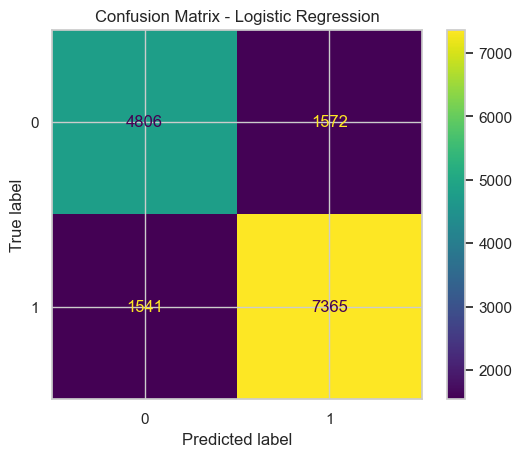

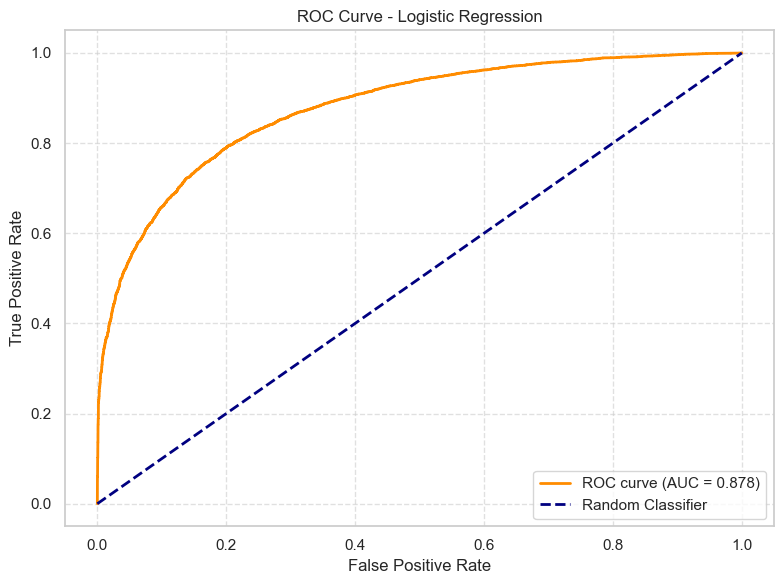

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  1  1
--------------------------------------------------------------------------------
Model: Decision Tree
Accuracy:     0.740
Precision:    0.761
Recall:       0.809
F1-score:     0.784
ROC AUC:      0.808
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67      6378
           1       0.76      0.81      0.78      8906

    accuracy                           0.74     15284
   macro avg       0.73      0.73      0.73     15284
weighted avg       0.74      0.74      0.74     15284

--------------------------------------------------------------------------------


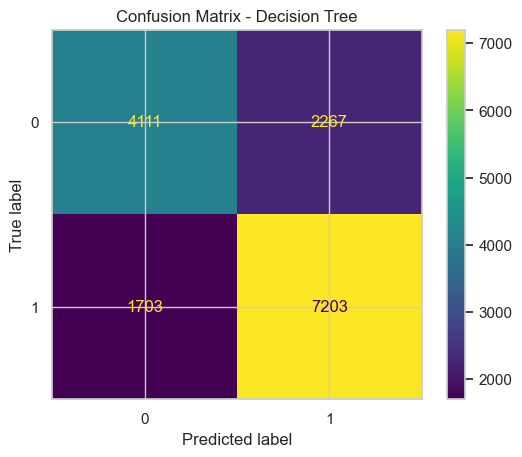

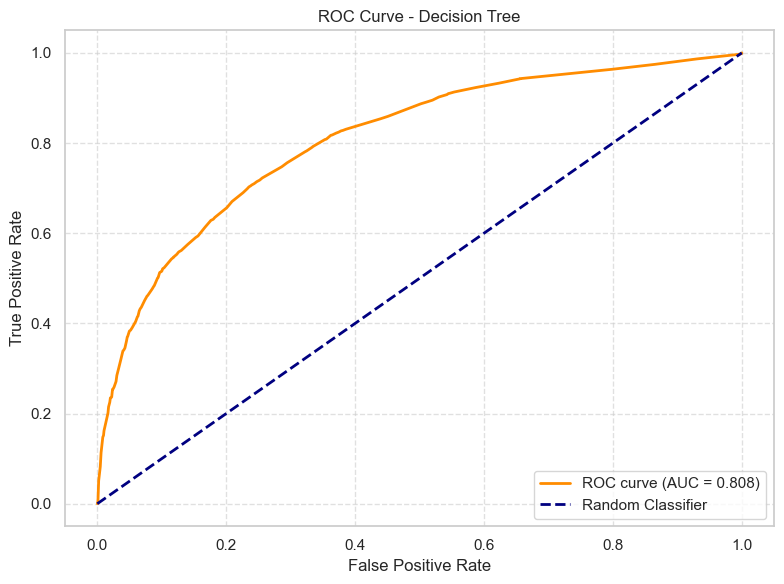

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  0  1
--------------------------------------------------------------------------------
Model: KNN
Accuracy:     0.716
Precision:    0.847
Recall:       0.625
F1-score:     0.720
ROC AUC:      0.819
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.84      0.71      6378
           1       0.85      0.63      0.72      8906

    accuracy                           0.72     15284
   macro avg       0.73      0.73      0.72     15284
weighted avg       0.75      0.72      0.72     15284

--------------------------------------------------------------------------------


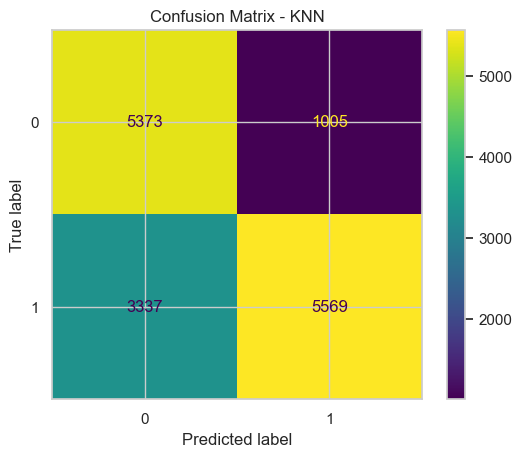

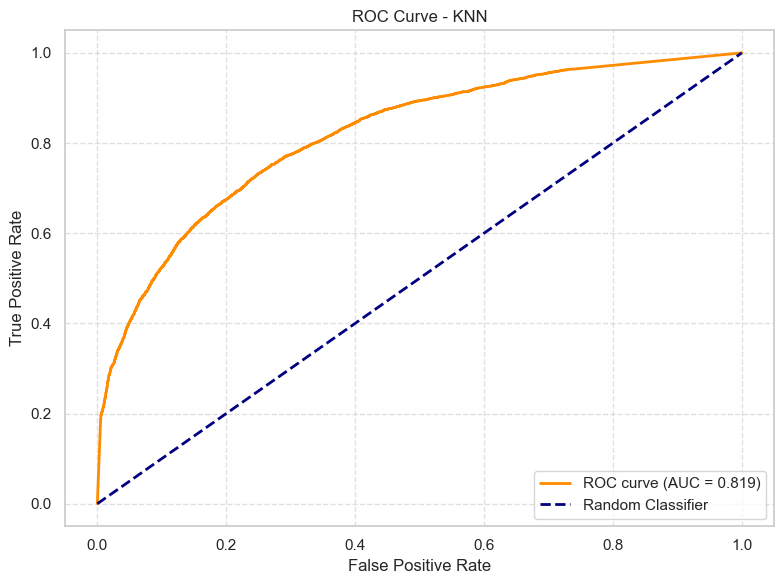

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  1  0  0  1  1  1  1
--------------------------------------------------------------------------------
Model: LDA
Accuracy:     0.745
Precision:    0.832
Recall:       0.705
F1-score:     0.763
ROC AUC:      0.827
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      6378
           1       0.83      0.70      0.76      8906

    accuracy                           0.74     15284
   macro avg       0.75      0.75      0.74     15284
weighted avg       0.76      0.74      0.75     15284

--------------------------------------------------------------------------------


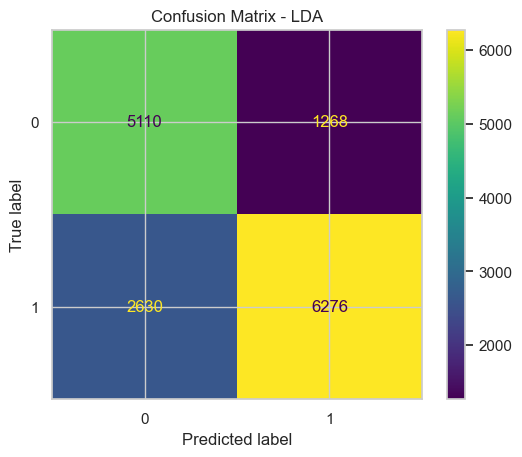

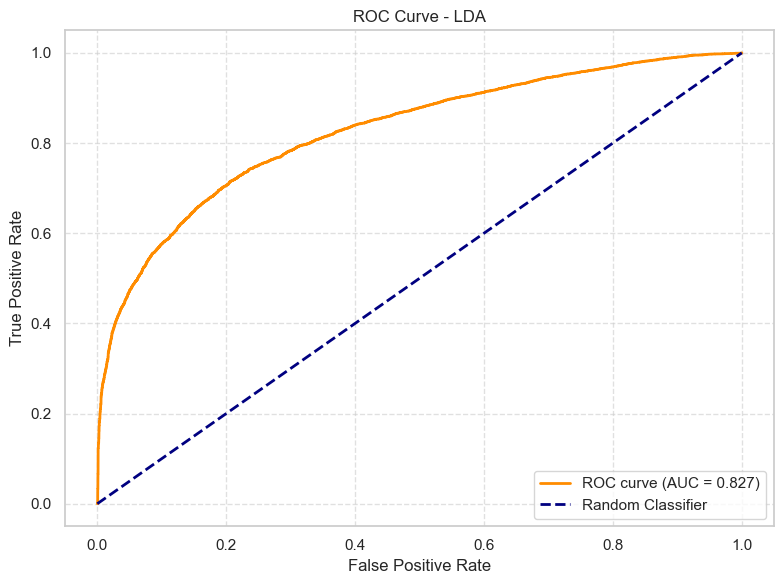

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  1  1
--------------------------------------------------------------------------------
Model: Naive Bayes
Accuracy:     0.714
Precision:    0.812
Recall:       0.662
F1-score:     0.729
ROC AUC:      0.797
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.70      6378
           1       0.81      0.66      0.73      8906

    accuracy                           0.71     15284
   macro avg       0.72      0.72      0.71     15284
weighted avg       0.73      0.71      0.72     15284

--------------------------------------------------------------------------------


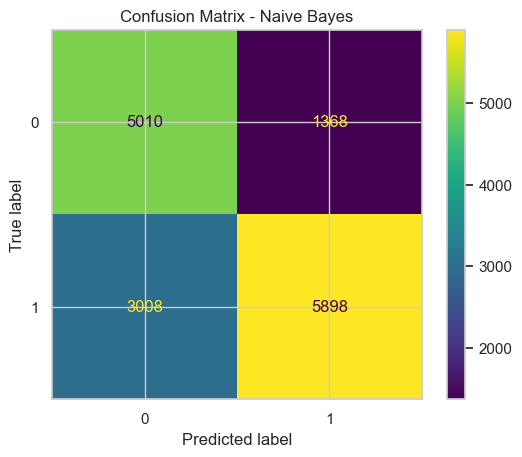

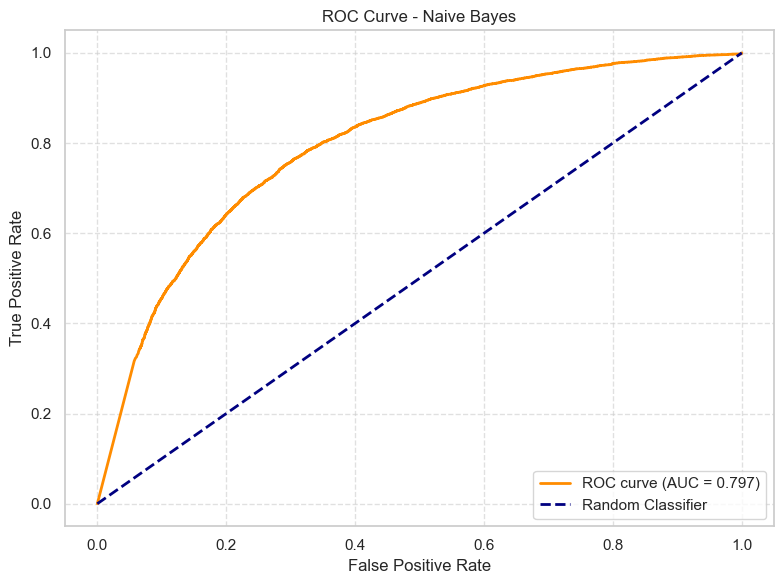

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  0  0  0  1  1
--------------------------------------------------------------------------------
Model: Random Forest
Accuracy:     0.813
Precision:    0.822
Recall:       0.867
F1-score:     0.844
ROC AUC:      0.896
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      6378
           1       0.82      0.87      0.84      8906

    accuracy                           0.81     15284
   macro avg       0.81      0.80      0.81     15284
weighted avg       0.81      0.81      0.81     15284

--------------------------------------------------------------------------------


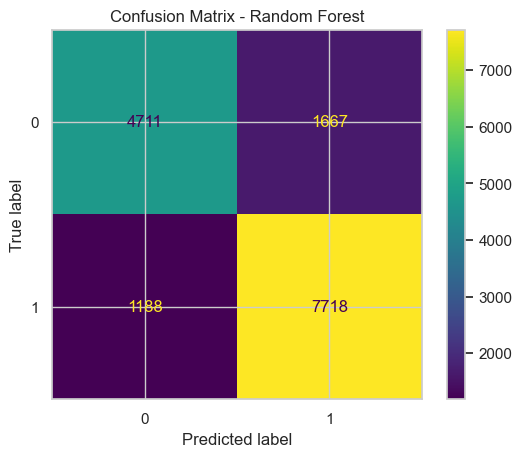

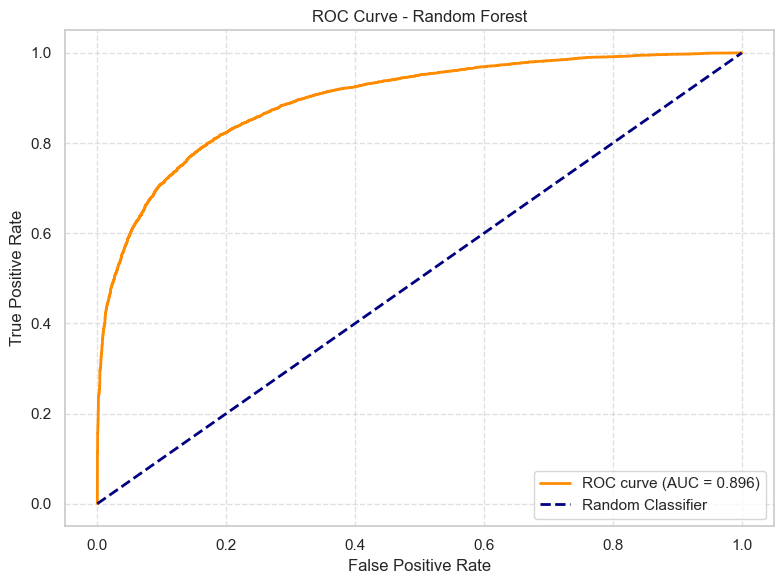

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  1  1
--------------------------------------------------------------------------------


In [54]:

# Lista de modelos con sus mejores parámetros
modelos = [
    (LogisticRegression(C=10, solver='liblinear', max_iter=1000), "Logistic Regression"),
    (DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42), "Decision Tree"),
    (KNeighborsClassifier(n_neighbors=7, weights='distance'), "KNN"),
    (LinearDiscriminantAnalysis(solver='lsqr'), 'LDA'),
    (GaussianNB(), "Naive Bayes"),
    (RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, random_state=42), "Random Forest"),
]



for modelo, nombre in modelos:
    predict_cv_2(modelo, nombre, X_scaled, y)


Model: gradient boosting
Accuracy:     0.828
Precision:    0.851
Recall:       0.855
F1-score:     0.853
ROC AUC:      0.910
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      6378
           1       0.85      0.85      0.85      8906

    accuracy                           0.83     15284
   macro avg       0.82      0.82      0.82     15284
weighted avg       0.83      0.83      0.83     15284

--------------------------------------------------------------------------------


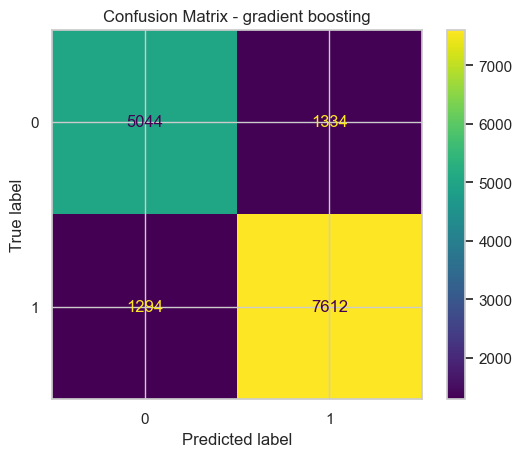

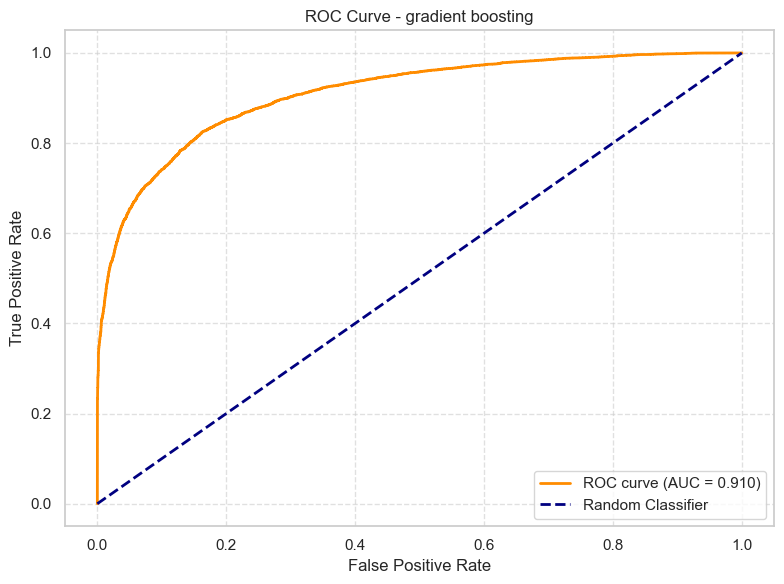

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  1  1
--------------------------------------------------------------------------------


GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

In [55]:
grad= GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

predict_cv_2(grad, 'gradient boosting', X_scaled, y)

Model: AdaBoost
Accuracy:     0.792
Precision:    0.818
Recall:       0.827
F1-score:     0.822
ROC AUC:      0.876
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      6378
           1       0.82      0.83      0.82      8906

    accuracy                           0.79     15284
   macro avg       0.79      0.78      0.79     15284
weighted avg       0.79      0.79      0.79     15284

--------------------------------------------------------------------------------


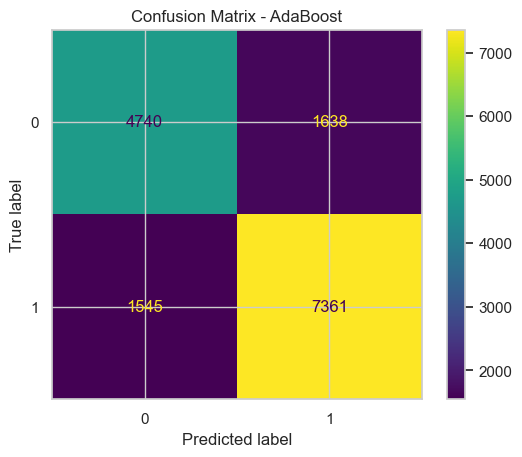

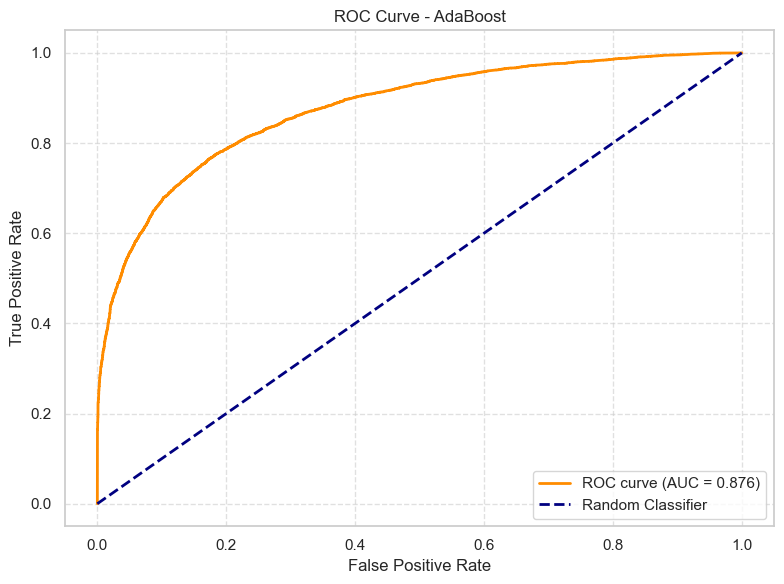

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  1  0
--------------------------------------------------------------------------------


AdaBoostClassifier(n_estimators=100, random_state=42)

In [56]:
ada=AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
predict_cv_2(ada, "AdaBoost", X_scaled, y)

c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:55:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:55:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:55:4

Model: XGB Opt
Accuracy:     0.831
Precision:    0.855
Recall:       0.855
F1-score:     0.855
ROC AUC:      0.911
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6378
           1       0.85      0.85      0.85      8906

    accuracy                           0.83     15284
   macro avg       0.83      0.83      0.83     15284
weighted avg       0.83      0.83      0.83     15284

--------------------------------------------------------------------------------


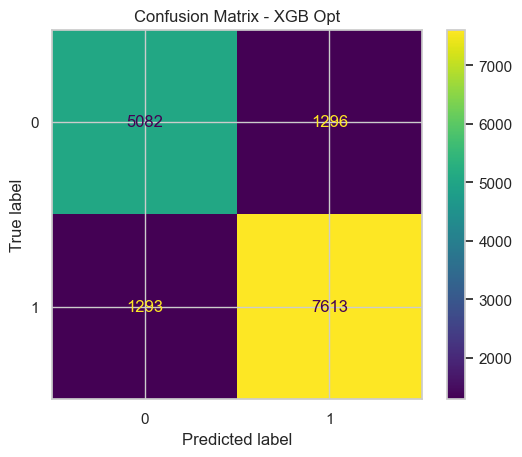

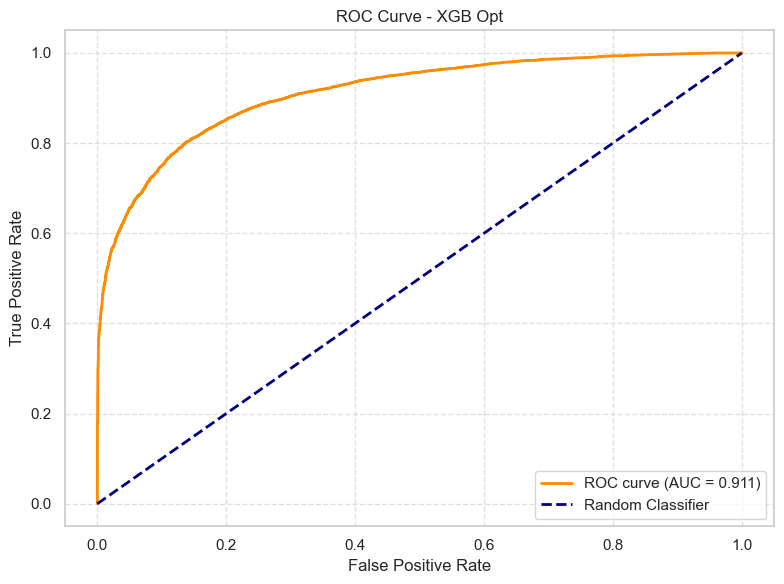

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  1  1
--------------------------------------------------------------------------------


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [58]:
xgb_best = XGBClassifier(
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=1.0,
    use_label_encoder=False,
    random_state=42
)

predict_cv_2(xgb_best, 'XGB Opt', X_scaled, y)

c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:56:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:56:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:56:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:56:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Model: XGB + PCA
Accuracy:     0.779
Precision:    0.798
Recall:       0.831
F1-score:     0.814
ROC AUC:      0.859
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      6378
           1       0.80      0.83      0.81      8906

    accuracy                           0.78     15284
   macro avg       0.77      0.77      0.77     15284
weighted avg       0.78      0.78      0.78     15284

--------------------------------------------------------------------------------


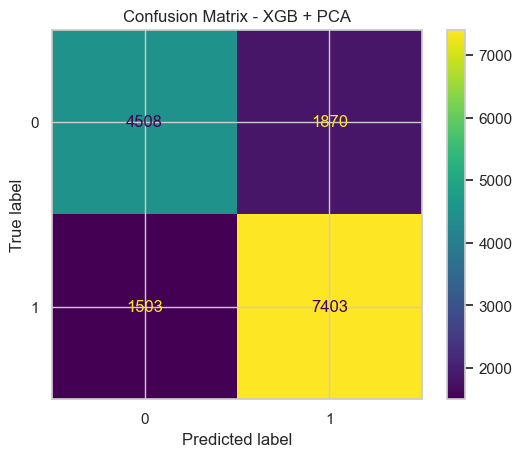

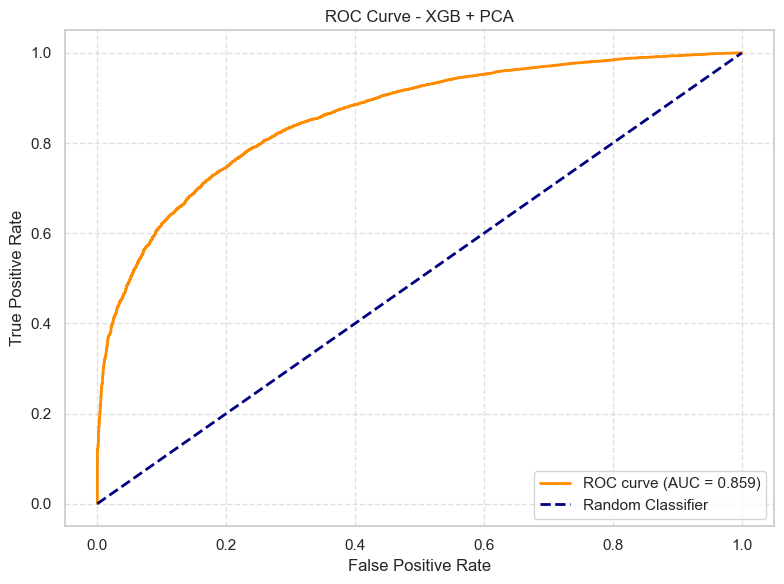

Predictions sample:
          0  1  2  3  4  5  6  7  8  9
y_actual  1  0  0  1  0  1  1  1  1  1
y_pred    1  0  0  0  0  1  1  1  1  1
--------------------------------------------------------------------------------


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [59]:
predict_cv_2(xgb_best,"XGB + PCA", X_pca, y)


# Resultados

In [60]:
model_result = pd.DataFrame(model_result_1)

In [61]:
round(model_result.sort_values("model"),3)

,model,cv_accuracy,cv_precision,cv_recall,cv_f1,cv_roc_auc
7,AdaBoost,0.792,0.818,0.827,0.822,0.876
1,Decision Tree,0.740,0.761,0.809,0.784,0.808
2,KNN,0.716,0.847,0.625,0.720,0.819
3,LDA,0.745,0.832,0.705,0.763,0.827
0,Logistic Regression,0.796,0.824,0.827,0.826,0.878
4,Naive Bayes,0.714,0.812,0.662,0.729,0.797
5,Random Forest,0.813,0.822,0.867,0.844,0.896
9,XGB + PCA,0.779,0.798,0.831,0.814,0.859
8,XGB Opt,0.831,0.855,0.855,0.855,0.911
6,gradient boosting,0.828,0.851,0.855,0.853,0.910


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:13:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.





🏅 Top 20 características más importantes:
             feature  importance
117        V3_median    0.047732
9           I_energy    0.024838
152      V5_dom_freq    0.024104
0                age    0.024029
93         V1_energy    0.023441
21           II_skew    0.023125
54      AVR_dom_freq    0.021953
166      V6_dom_freq    0.021366
65        AVL_energy    0.018404
110      V2_dom_freq    0.017318
37        III_energy    0.016807
131        V4_median    0.016067
149        V5_energy    0.015064
47        AVR_median    0.015058
95   V1_spec_entropy    0.012100
144           V5_max    0.011671
135        V4_energy    0.010818
165  V6_spec_entropy    0.010638
12        I_dom_freq    0.009922
49          AVR_skew    0.009747


C:\Users\perez\AppData\Local\Temp\ipykernel_17516\1901411447.py:22: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.



<Figure size 1000x800 with 0 Axes>

c:\Users\perez\Documents\cursomchl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.



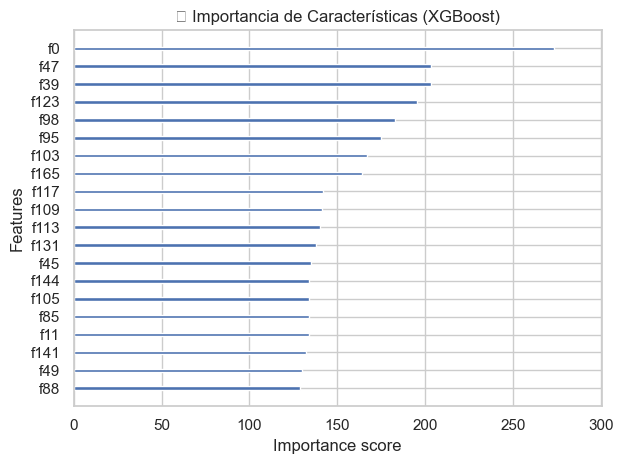

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Asumiendo que tienes el mejor estimador entrenado como:

# Asegúrate de que está entrenado con los datos completos
xgb_best.fit(X_scaled, y)

# 1️⃣ Mostrar importancia de forma tabular
importances = xgb_best.feature_importances_
features = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X.shape[1])]
importancia_df = pd.DataFrame({'feature': features, 'importance': importances})
importancia_df = importancia_df.sort_values(by='importance', ascending=False)

print("\n🏅 Top 20 características más importantes:")
print(importancia_df.head(20))

# 2️⃣ Gráfico de las 20 características más importantes
plt.figure(figsize=(10, 8))
plot_importance(xgb_best, max_num_features=20, importance_type='weight', show_values=False)
plt.title("📊 Importancia de Características (XGBoost)")
plt.tight_layout()
plt.show()


# Estabilidad del modelo

In [ ]:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(xgb_best, X_scaled, y, scoring='roc_auc', cv=cv)

print(f"🏁 ROC AUC media: {scores.mean():.4f}")
print(f"📉 Desviación estándar: {scores.std():.4f}")


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:19:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:19:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:19:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:19:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[16:19:4

🏁 ROC AUC media: 0.9120
📉 Desviación estándar: 0.0041


In [ ]:
def calculate_psi(expected, actual, bins=10):
    """
    Calcula el PSI entre dos distribuciones (expected vs actual).
    :param expected: Distribución base (e.g., entrenamiento)
    :param actual: Distribución nueva (e.g., producción)
    :param bins: Número de bins (percentiles)
    :return: Valor PSI
    """
    expected = np.array(expected)
    actual = np.array(actual)

    # Evitar bins duplicados
    try:
        breakpoints = np.unique(np.percentile(expected, np.linspace(0, 100, bins + 1)))
        if len(breakpoints) - 1 < bins:
            bins = len(breakpoints) - 1
    except Exception as e:
        raise ValueError(f"Error generando breakpoints: {e}")

    expected_counts, _ = np.histogram(expected, bins=breakpoints)
    actual_counts, _ = np.histogram(actual, bins=breakpoints)

    expected_percents = expected_counts / len(expected)
    actual_percents = actual_counts / len(actual)

    # Evitar log(0) o división por cero
    expected_percents = np.where(expected_percents == 0, 1e-6, expected_percents)
    actual_percents = np.where(actual_percents == 0, 1e-6, actual_percents)

    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi = np.sum(psi_values)

    return psi



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Dividir los datos
X = df.drop(columns=['NOT_NORM', 'ecg_id', 'date', 'mes', 'año'])
y = df['NOT_NORM'].astype(int)

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.3, random_state=42, stratify=y
)

# Entrenar modelo
xgb_best.fit(X_train, y_train)

# Predicciones
df_train = df_train.copy()
df_test = df_test.copy()
df_train['pred'] = xgb_best.predict_proba(X_train)[:, 1]
df_test['pred'] = xgb_best.predict_proba(X_test)[:, 1]


c:\Users\perez\Documents\cursomchl\Lib\site-packages\xgboost\training.py:183: UserWarning:

[17:51:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [ ]:
train_preds = df_train['pred']
psi_por_mes = []

for mes, grupo in df_test.groupby('mes'):
    psi = calculate_psi(train_preds, grupo['pred'])
    psi_por_mes.append((str(mes), psi))

df_psi = pd.DataFrame(psi_por_mes, columns=['mes', 'psi'])
print(df_psi)


         mes        psi
0    1984-11  12.432962
1    1984-12  12.432962
2    1985-01   9.015928
3    1985-02  10.564854
4    1985-03  12.432962
..       ...        ...
188  2000-12   2.802891
189  2001-01   1.770502
190  2001-02  10.496438
191  2001-05   8.899941
192  2001-06  12.432962

[193 rows x 2 columns]


In [ ]:
train_preds = df_train['pred']
psi_por_mes = []

for mes, grupo in df_test.groupby('año'):
    psi = calculate_psi(train_preds, grupo['pred'])
    psi_por_mes.append((str(mes), psi))

df_psi = pd.DataFrame(psi_por_mes, columns=['año', 'psi'])
print(df_psi)

     año        psi
0   1984  12.432962
1   1985   5.225847
2   1986   0.979508
3   1987   0.433369
4   1988   0.706364
5   1989   0.457308
6   1990   0.534282
7   1991   0.513447
8   1992   0.490795
9   1993   0.431211
10  1994   0.541521
11  1995   0.453087
12  1996   0.612824
13  1997   0.538049
14  1998   0.557628
15  1999   0.410837
16  2000   0.674867
17  2001   0.657708


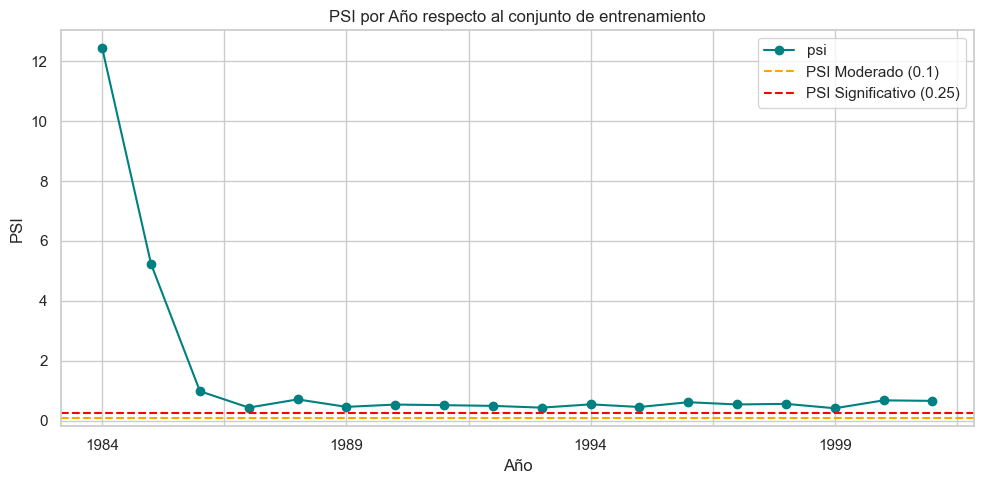

In [ ]:
import matplotlib.pyplot as plt

df_psi.set_index('año')['psi'].plot(marker='o', figsize=(10,5), color='teal')
plt.axhline(0.1, color='orange', linestyle='--', label='PSI Moderado (0.1)')
plt.axhline(0.25, color='red', linestyle='--', label='PSI Significativo (0.25)')
plt.title("PSI por Año respecto al conjunto de entrenamiento")
plt.ylabel("PSI")
plt.xlabel("Año")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
resultados = []

for año, grupo in df_test.groupby(df_test['date'].dt.year):
    if grupo['NOT_NORM'].nunique() < 2:
        continue  # No se puede calcular AUC si hay solo una clase

    # Prepara los datos para predicción
    X_grupo = grupo[X.columns]  # usa las mismas columnas que usaste en entrenamiento
    y_true = grupo['NOT_NORM'].astype(int)
    
    # Predicciones
    y_proba = xgb_best.predict_proba(X_grupo)[:, 1]
    y_pred_bin = (y_proba > 0.5).astype(int)
    
    # Asegura igualdad de tamaño
    assert len(y_true) == len(y_pred_bin), f"Tamaños diferentes: {len(y_true)} vs {len(y_pred_bin)}"

    resultados.append({
        'año': año,
        'n': len(grupo),
        'auc': roc_auc_score(y_true, y_proba),
        'f1': f1_score(y_true, y_pred_bin)
    })

df_metricas = pd.DataFrame(resultados)
print(df_metricas)


     año    n       auc        f1
0   1984    3  0.000000  0.000000
1   1985   30  0.888000  0.888889
2   1986   52  0.897929  0.800000
3   1987  185  0.899462  0.791209
4   1988  236  0.905559  0.827004
5   1989  285  0.907362  0.849315
6   1990  370  0.900945  0.861048
7   1991  394  0.899530  0.828829
8   1992  413  0.931854  0.862745
9   1993  464  0.922147  0.869888
10  1994  413  0.904349  0.830579
11  1995  398  0.912900  0.853503
12  1996  406  0.911670  0.855469
13  1997  322  0.893594  0.834171
14  1998  233  0.924215  0.893333
15  1999  168  0.950154  0.902326
16  2000  155  0.943694  0.910714
17  2001   40  0.917333  0.920000


In [ ]:
from scipy.stats import ks_2samp
# Filtra las predicciones por clase
y_pos = y_proba[y_true == 1]
y_neg = y_proba[y_true == 0]

# Calcular KS
ks_stat = ks_2samp(y_pos, y_neg).statistic

In [ ]:
from scipy.stats import ks_2samp

resultados = []

for año, grupo in df_test.groupby(df_test['date'].dt.year):
    if grupo['NOT_NORM'].nunique() < 2:
        continue

    X_grupo = grupo[X.columns]
    y_true = grupo['NOT_NORM'].astype(int)
    y_proba = xgb_best.predict_proba(X_grupo)[:, 1]
    y_pred_bin = (y_proba > 0.5).astype(int)

    y_pos = y_proba[y_true == 1]
    y_neg = y_proba[y_true == 0]
    ks = ks_2samp(y_pos, y_neg).statistic if len(y_pos) > 0 and len(y_neg) > 0 else np.nan

    resultados.append({
        'año': año,
        'n': len(grupo),
        'auc': roc_auc_score(y_true, y_proba),
        'f1': f1_score(y_true, y_pred_bin),
        'ks': ks
    })

df_metricas = pd.DataFrame(resultados)
print(df_metricas)


     año    n       auc        f1        ks
0   1984    3  0.000000  0.000000  1.000000
1   1985   30  0.888000  0.888889  0.800000
2   1986   52  0.897929  0.800000  0.653846
3   1987  185  0.899462  0.791209  0.657420
4   1988  236  0.905559  0.827004  0.694915
5   1989  285  0.907362  0.849315  0.713659
6   1990  370  0.900945  0.861048  0.695574
7   1991  394  0.899530  0.828829  0.644828
8   1992  413  0.931854  0.862745  0.708458
9   1993  464  0.922147  0.869888  0.721116
10  1994  413  0.904349  0.830579  0.644558
11  1995  398  0.912900  0.853503  0.674407
12  1996  406  0.911670  0.855469  0.665380
13  1997  322  0.893594  0.834171  0.619324
14  1998  233  0.924215  0.893333  0.729903
15  1999  168  0.950154  0.902326  0.822222
16  2000  155  0.943694  0.910714  0.760647
17  2001   40  0.917333  0.920000  0.866667


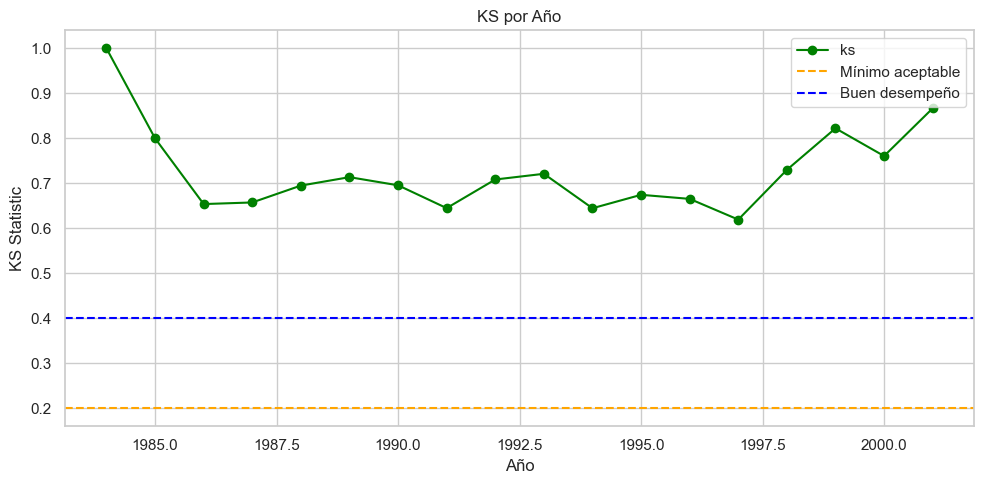

In [ ]:
df_metricas.set_index('año')['ks'].plot(marker='o', figsize=(10,5), color='green')
plt.axhline(0.2, linestyle='--', color='orange', label='Mínimo aceptable')
plt.axhline(0.4, linestyle='--', color='blue', label='Buen desempeño')
plt.title("KS por Año")
plt.ylabel("KS Statistic")
plt.xlabel("Año")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Creación de la clase y el pipeline para su exportación


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import wfdb
import joblib
from scipy.stats import skew, kurtosis, iqr
from scipy.signal import welch, find_peaks
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

class CDD_G29_M2_E1_Kevin_Perez_Alvarez(BaseEstimator, TransformerMixin):
    def __init__(self, csv_path, base_dir, drop_cols=None, xgb_params=None):
        self.csv_path = csv_path
        self.base_dir = base_dir
        self.drop_cols = drop_cols if drop_cols is not None else ['NOT_NORM', 'ecg_id', 'date', 'mes', 'año']
        self.scaler = MinMaxScaler()
        self.num_cols = None
        self.xgb_params = xgb_params if xgb_params is not None else {
            'eval_metric': 'logloss',
            'learning_rate': 0.1,
            'max_depth': 7,
            'n_estimators': 200,
            'subsample': 0.8,
            'colsample_bytree': 1.0,
            'use_label_encoder': False,
            'random_state': 42
        }
        self.model = XGBClassifier(**self.xgb_params)

    def spectral_entropy(self, psd):
        psd_norm = psd / np.sum(psd)
        return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

    def estimate_hr(self, signal, fs):
        peaks, _ = find_peaks(signal, distance=fs*0.6)
        if len(peaks) < 2:
            return np.nan
        rr_intervals = np.diff(peaks) / fs
        hr = 60.0 / np.mean(rr_intervals)
        return hr

    def zero_crossings(self, signal):
        return ((signal[:-1] * signal[1:]) < 0).sum()

    def extract_features(self, record, row):
        data = record.p_signal
        fs = record.fs
        feature_dict = {
            'ecg_id': row.get('ecg_id', np.nan),
            'age': row.get('age', np.nan),
            'sex': row.get('sex', np.nan),
            'decive': row.get('device', np.nan),
            'date': row.get('recording_date', np.nan),
            'NOT_NORM': row.get('NOT_NORM', np.nan),
        }
        for i, name in enumerate(record.sig_name):
            canal = data[:, i]
            feature_dict[f'{name}_mean'] = np.mean(canal)
            feature_dict[f'{name}_std'] = np.std(canal)
            feature_dict[f'{name}_min'] = np.min(canal)
            feature_dict[f'{name}_max'] = np.max(canal)
            feature_dict[f'{name}_median'] = np.median(canal)
            feature_dict[f'{name}_iqr'] = iqr(canal)
            feature_dict[f'{name}_skew'] = skew(canal)
            feature_dict[f'{name}_kurtosis'] = kurtosis(canal)
            feature_dict[f'{name}_energy'] = np.sum(canal ** 2)
            feature_dict[f'{name}_rms'] = np.sqrt(np.mean(canal ** 2))
            freqs, psd = welch(canal, fs=fs)
            feature_dict[f'{name}_spec_entropy'] = self.spectral_entropy(psd)
            feature_dict[f'{name}_dom_freq'] = freqs[np.argmax(psd)]
            feature_dict[f'{name}_hr_est'] = self.estimate_hr(canal, fs)
            feature_dict[f'{name}_zero_cross'] = self.zero_crossings(canal)
        return feature_dict

    def fit(self, X=None, y=None):
        df = pd.read_csv(self.csv_path)
        features = [
            self.extract_features(
                wfdb.rdrecord(os.path.normpath(os.path.join(self.base_dir, row['filename_hr']))),
                row
            )
            for _, row in tqdm(df.iterrows(), total=len(df))
        ]
        df_features = pd.DataFrame(features)

        df_features["ecg_id"] = df_features["ecg_id"].astype(str)
        df_features["sex"] = df_features["sex"].astype(str)
        df_features["NOT_NORM"] = df_features["NOT_NORM"].astype(str)
        df_features["decive"] = df_features["decive"].astype(str)
        df_features['date'] = pd.to_datetime(df_features['date'], errors='coerce')
        df_features['mes'] = df_features['date'].dt.to_period('M')
        df_features['año'] = df_features['date'].dt.to_period('Y')

        df_model = pd.get_dummies(df_features, columns=['sex', 'decive', 'año'], drop_first=True)
        X_model = df_model.drop(columns=self.drop_cols, errors='ignore')
        y_model = df_features['NOT_NORM'].astype(int)

        self.num_cols = X_model.select_dtypes(include=[np.number]).columns.tolist()
        self.scaler.fit(X_model[self.num_cols])
        
        self.df_features_ = df_features
        self.df_model_ = df_model
        self.X_model_ = X_model
        self.y_model_ = y_model
        return self

    def split_data(self, test_size=0.3, random_state=42):
        self.X_train_, self.X_test_, self.y_train_, self.y_test_ = train_test_split(
            self.X_model_, self.y_model_, test_size=test_size, random_state=random_state, stratify=self.y_model_
        )

    def fit_model(self):
        X_scaled = self.scaler.transform(self.X_train_[self.num_cols])
        self.model.fit(X_scaled, self.y_train_)

    def score_auc(self):
        X_test_scaled = self.scaler.transform(self.X_test_[self.num_cols])
        y_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        return roc_auc_score(self.y_test_, y_proba)

    def transform(self, X=None):
        if X is None:
            X_model = self.X_model_
        else:
            X_model = X.drop(columns=self.drop_cols, errors='ignore')
        X_num = X_model[self.num_cols]
        X_scaled = pd.DataFrame(self.scaler.transform(X_num), columns=self.num_cols, index=X_model.index)
        return X_scaled

    def predict(self, X=None):
        X_scaled = self.transform(X)
        return self.model.predict(X_scaled)

    def predict_proba(self, X=None):
        X_scaled = self.transform(X)
        return self.model.predict_proba(X_scaled)

    def export_pipeline(self, path='ecg_pipeline.pkl'):
        joblib.dump(self, path)
        print(f"✅ Pipeline guardado en {path}")

    @staticmethod
    def load_pipeline(path='ecg_pipeline.pkl'):
        return joblib.load(path)

In [ ]:
# Ejemplo de uso:
pipe = CDD_G29_M2_E1_Kevin_Perez_Alvarez(csv_path="train_e1.csv", base_dir="records500")
pipe.fit()
pipe.split_data()
pipe.fit_model()
print(f"AUC: {pipe.score_auc():.4f}")
pipe.export_pipeline("CDD_G29_M2_E1_Kevin_Perez_Alvarez.pkl")


AUC: 0.9092
✅ Pipeline guardado en CDD_G29_M2_E1_Kevin_Perez_Alvarez.pkl


In [ ]:
pipe_loaded = CDD_G29_M2_E1_Kevin_Perez_Alvarez.load_pipeline("CDD_G29_M2_E1_Kevin_Perez_Alvarez.pkl")


In [ ]:
import pandas as pd
import wfdb
import os
from tqdm import tqdm

# Leer test_e1.csv que contiene 'ecg_id' y 'filename_hr' al menos
df_test = pd.read_csv("test_e1.csv")

# Extraer características como se hizo en .fit()
features = []
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    record_path = os.path.join(pipe.base_dir, row['filename_hr'])
    record = wfdb.rdrecord(os.path.normpath(record_path))
    feats = pipe.extract_features(record, row)
    features.append(feats)

df_features_test = pd.DataFrame(features)

# Procesamiento igual al training
df_features_test["ecg_id"] = df_features_test["ecg_id"].astype(str)
df_features_test["sex"] = df_features_test["sex"].astype(str)
df_features_test["decive"] = df_features_test["decive"].astype(str)
df_features_test["date"] = pd.to_datetime(df_features_test["date"], errors='coerce')
df_features_test['año'] = df_features_test['date'].dt.to_period('Y')

# Dummies igual que en entrenamiento
df_model_test = pd.get_dummies(df_features_test, columns=['sex', 'decive', 'año'], drop_first=True)

# Asegurar que las columnas coincidan con entrenamiento (falta dummy alignment)
for col in pipe.X_model_.columns:
    if col not in df_model_test.columns:
        df_model_test[col] = 0
df_model_test = df_model_test[pipe.X_model_.columns]

# Predecir probabilidades
X_test_scaled = pipe.scaler.transform(df_model_test[pipe.num_cols])
probs = pipe.model.predict_proba(X_test_scaled)[:, 1]

# Resultados con ecg_id
df_resultados = pd.DataFrame({
    'ecg_id': df_features_test['ecg_id'],
    'y_hat': probs
})

print(df_resultados.head())


  ecg_id     y_hat
0  14710  0.870774
1   6122  0.817975
2  20616  0.990222
3   7603  0.997728
4   5768  0.728243


In [ ]:
df_resultados.to_csv("CDD_G29_M2_E1_Kevin_Perez_Alvarez.csv", index=False)
